<a href="https://colab.research.google.com/github/RoozbehSanaei/DSM_Repository/blob/master/Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Load DSM from Git ,install dgl and import neccessary libraries**

In [1]:
!pip install dgl
!git clone https://github.com/RoozbehSanaei/DSM_Repository.git

import torch
import numpy as np
import torch.nn.functional as F
from copy import deepcopy as dc
import dgl
import dgl.function as fn
import torch.nn as nn
import csv
import tqdm
from random import randint
import sys

np.set_printoptions(threshold=sys.maxsize)

     |████████████████████████████████| 2.4MB 3.5MB/s 
Cloning into 'DSM_Repository'...
remote: Enumerating objects: 16, done.
remote: Counting objects: 100% (16/16), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 16 (delta 3), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (16/16), done.


**Utility Functions**

In [0]:
class mean_val:
    def __init__(self):
        self.k = 0
        self.val = 0
        self.mean = 0
        
    def add(self,x):
        self.k += 1
        self.val += x
        self.mean = self.val/self.k
        
    def get(self):
        return self.mean
        
    
class logger:
    def __init__(self):
        self.log = dict()
        
    def add_log(self,name):
        self.log[name] = []
        
    def add_item(self,name,x):
        self.log[name].append(x)
        
    def get_log(self,name):
        return self.log[name]
    
    def get_current(self,name):
        return self.log[name][-1]
    
    def get_keys(self):
        return self.log.keys() 


def stack_indices(idx,n_nodes):
    sum_n = 0
    for i in range(len(n_nodes)-1):
        sum_n += n_nodes[i]
        idx[i+1] += sum_n
    return idx

def stack_list_indices(idx,n_nodes):
    sum_n = 0
    #out = []
    for i in range(len(n_nodes)-1):
        sum_n += n_nodes[i]
        for j in range(len(idx[i+1])):
            idx[i+1][j] += sum_n
    merged = list(itertools.chain(*idx))
    return merged

def max_graph_array(array,n_outs,masks):
    adds = 0
    count = 0
    idx = []
    for i in range(len(n_outs)):
        arr = array[count:(count+n_outs[i]),0].squeeze()
        min_arr = arr.min().item()
        arr = arr - min_arr + 1.0
        arr[masks[i].squeeze()] = 0.0
        idx.append(arr.argmax() + adds)
        adds += n_outs[i]
    out_idx = torch.LongTensor(idx)
    out_val = array[out_idx]
    return out_idx,out_val    

**Graph Convolutional Models**

In [0]:
msg = fn.copy_src(src='h', out='m')

def reduce(nodes):
    accum = torch.cat((torch.mean(nodes.mailbox['m'], 1),torch.max(nodes.mailbox['m'],1)[0]),dim=1)
    return {'hm': accum}

class NodeApplyModule(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(NodeApplyModule, self).__init__()
        self.linear = nn.Linear(3*in_feats, out_feats)
        self.activation = activation

    def forward(self, node):
        h = self.linear(torch.cat((node.data['h'],node.data['hm']),dim=1))
        h = self.activation(h)
        return {'h' : h}

class GCN(nn.Module):
    def __init__(self, in_feats, out_feats, activation):
        super(GCN, self).__init__()
        self.apply_mod = NodeApplyModule(in_feats, out_feats, activation)

    def forward(self, g, feature):
        g.ndata['h'] = feature
        g.update_all(msg, reduce)
        g.apply_nodes(func=self.apply_mod)
        g.ndata.pop('hm')
        return g.ndata.pop('h')


class ACNet(nn.Module):
    def __init__(self, in_dim, hidden_dim, n_classes):
        super(ACNet, self).__init__()
        
        self.policy = nn.Linear(hidden_dim,n_classes)
        self.value = nn.Linear(hidden_dim,1)
        self.layers = nn.ModuleList([
            GCN(in_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu),
            GCN(hidden_dim, hidden_dim, F.relu)])
            

    def forward(self, g):
        h = g.ndata['x']
        for conv in self.layers:
            h = conv(g, h)
        g.ndata['h'] = h
        mN = dgl.mean_nodes(g, 'h')
        PI = self.policy(g.ndata['h'])
        V = self.value(mN)
        g.ndata.pop('h')
        return PI, V
    

**Discrete Actor Critic Reinforcement Learning**

In [0]:
def convert2dgl(DSM,cluster_seq):
    G = dgl.DGLGraph()
    G.add_nodes(DSM.shape[0])
    for i in range(DSM.shape[0]):
        for j in range(DSM.shape[1]):
            if DSM[i][j]:
                G.add_edge(i, j)
    G.ndata['x'] = torch.from_numpy(np.array([cluster_seq]).transpose()).float()
    return G


class DiscreteActorCritic:
    def __init__(self, problem, cuda_flag):
        self.problem = problem
        if cuda_flag:
            self.model = ACNet(1,200,50).cuda()
        else:
            self.model = ACNet(1,200,50)
        self.gamma = 0.98
        self.optimizer = torch.optim.Adam(self.model.parameters(),lr=0.0003)
        self.batch_size = 200
        self.num_episodes = 1
        self.cuda = cuda_flag
        self.log = logger()
        self.log.add_log('tot_return')
        self.log.add_log('TD_error')
        self.log.add_log('entropy')


    def run_episode(self):
        sum_r = 0
        t = 0
        for i in range(200):
            G = dc(self.problem.g)
            if self.cuda:
                G.ndata['x'] = G.ndata['x'].cuda()
            [pi,val] = self.model(G)
            pi = pi.squeeze()
            pi = F.softmax(pi,dim=0)
            pi = pi.reshape((2500,))
            dist = torch.distributions.categorical.Categorical(pi)
            action = dist.sample()
            action2 = np.unravel_index(dist.sample(),(50,50))
            reward = torch.tensor(self.problem.step(action2))
            sum_r += reward
            if (t==0):
                PI = pi[action].unsqueeze(0)
                R = reward.unsqueeze(0)
                V = val.unsqueeze(0)
                t += 1
            else:
                PI = torch.cat([PI,pi[action].unsqueeze(0)],dim=0)
                R = torch.cat([R,reward.unsqueeze(0)],dim=0)
                V = torch.cat([V,val.unsqueeze(0)],dim=0)
        self.log.add_item('tot_return',sum_r.item())
        tot_return = R.sum().item()
        for i in range(R.shape[0] - 1):
            R[-2-i] = R[-2-i] + self.gamma*R[-1-i]
            
        return PI, R, V, tot_return
    
    
    def update_model(self,PI,R,V):
        self.optimizer.zero_grad()
        if self.cuda:
            R = R.cuda()
        A = R.squeeze() - V.squeeze().detach()
        L_policy = -(torch.log(PI)*A).mean()
        L_value = F.smooth_l1_loss(V.squeeze(), R.squeeze())
        L_entropy = -(PI*PI.log()).mean()
        L = L_policy + L_value - 0.2*L_entropy
        L.backward()
        self.optimizer.step()
        self.log.add_item('TD_error',L_value.detach().item())
        self.log.add_item('entropy',L_entropy.cpu().detach().item())
        
    
    def train(self):
        mean_return = 0
        for i in range(self.num_episodes):
            [pi,r,v,tot_return] = self.run_episode()

            mean_return = mean_return + tot_return
            if (i == 0):
                PI = pi
                R = r
                V = v
            else:
                PI = torch.cat([PI,pi],dim=0)
                R = torch.cat([R,r],dim=0)
                V = torch.cat([V,v],dim=0)
        mean_return = mean_return/self.num_episodes
        self.update_model(PI,R,V)
        return self.log

**Clustering Algorithm**

Every clustering scheme can be represented as a sequence of numbers. where the number associated with each elements determines its cluster.


In [0]:

def fix(seq):
    c = 0
    d = dict()
    n = len(seq)
    for i in range(0,n):
        if not(seq[i] in d.keys()):
            d[seq[i]] = c
            c = c + 1
        seq[i] = d[seq[i]]

def seq_2_mat(seq):
    n = len(seq)
    m = max(seq)+1
    mat = np.zeros((m,n))
    mat[(seq,range(0,n))]=1
    return(mat)

def mat_2_seq(mat):
    seq = [np.nonzero(mat[:,i])[0][0] for i in range(mat.shape[1])]
    return (seq)



def cost(DSM,  cluster_matrix, pow_cc=1):
    dsm_size = DSM.shape[0]
    io = np.dot(np.dot(cluster_matrix, DSM), cluster_matrix.transpose())
    ioi = io.diagonal()
    ios = np.sum(io)
    iois = np.sum(ioi)
    ioe = ios - iois
    io_extra = ioe * dsm_size

    cluster_size = np.sum(cluster_matrix, axis=1)
    cscc = np.power(cluster_size, pow_cc)
    io_intra = np.dot(ioi, cscc)


    return (io_extra+io_intra)

class Clustering:
    def __init__(self,DSM,Constraints):
        self.DSM = DSM
        self.Constraints = Constraints
        self.N = DSM.shape[0]
        self.g = dgl.DGLGraph()
        self.g.add_nodes(self.N)
        for i in range(self.N):
            for j in range(self.N):
                if DSM[i][j]:
                    self.g.add_edge(i,j)
        self.cluster_seq = list(range(self.N))
        self.g.ndata['x'] = torch.from_numpy(np.array([self.cluster_seq]).transpose()).float()
        self.unchanged = 0
        self.cost = cost(self.DSM,  seq_2_mat(self.cluster_seq), pow_cc=1)
        self.min_cost = self.cost
        self.min_cluster_seq = self.cluster_seq
        self.cluster_seq_list = []
      

    def step(self,action):
        cluster_seq_new = self.cluster_seq.copy()

        cluster_seq_new[action[0]] = cluster_seq_new[action[1]]
        fix(cluster_seq_new)
        
        
        cluster_mat = seq_2_mat(cluster_seq_new)
        cluster_mat_trans = cluster_mat.transpose()
        elementwise_cluster = np.dot(cluster_mat_trans,cluster_mat)
        contraints_violation = np.sum((1-self.Constraints)*elementwise_cluster)
        new_cost = cost(self.DSM,  seq_2_mat(cluster_seq_new), pow_cc=1)

        if ((new_cost<self.cost) and (contraints_violation)==0):
            reward = self.cost - new_cost
            self.cost = new_cost
            print(len(self.cluster_seq_list),"cost:",self.cost,"effort:",self.unchanged)
            self.cluster_seq = cluster_seq_new
            self.cluster_seq_list = self.cluster_seq_list + [self.cluster_seq]
            self.g.ndata['x'] = torch.from_numpy(np.array([self.cluster_seq]).transpose()).float()
            self.unchanged = 0
            
        else:
            reward = self.cost - new_cost - 100*(contraints_violation)
            self.unchanged = self.unchanged + 1
            
        '''
        if (self.unchanged==10000): 
            i = len(self.cluster_seq_list)-randint(5,20)
            self.cluster_seq = self.cluster_seq_list[i].copy()
            self.cost = cost(self.DSM,  seq_2_mat(self.cluster_seq), pow_cc=1)
            print(len(self.cluster_seq_list),self.cost,self.unchanged)
            self.g.ndata['x'] = torch.from_numpy(np.array([self.cluster_seq]).transpose()).float()
            self.unchanged = 0
        '''
        
        if (self.cost < self.min_cost):
          self.min_cost = self.cost
          self.min_cluster_seq = self.cluster_seq
    
            
        
        return reward

**Read data from excel sheet, It contains DSM and Constrains**

In [0]:
import xlrd
book = xlrd.open_workbook('/content/DSM_Repository/contrast injector.xlsx')


sheet_data = book.sheet_by_name('DSM')
data = np.array([[sheet_data.cell_value(r, c) for c in range(sheet_data.ncols)] for r in range(sheet_data.nrows)])
DSM = data[1:,1:].astype(np.float32)
Components = data[1:,0]



sheet_constraints = book.sheet_by_name('Constraints')
constraints_data = np.array([[sheet_constraints.cell_value(r, c) for c in range(sheet_constraints.ncols)] for r in range(sheet_constraints.nrows)])
Constraints = constraints_data[1:,1:].astype(np.float32)


**Executation Loop**

In [10]:
env = Clustering(DSM,Constraints)
alg = DiscreteActorCritic(env,False)



num_episodes = 4000
for i in range(num_episodes):
    log = alg.train()  

0 cost: 5456.0 effort: 2
1 cost: 5362.0 effort: 0
2 cost: 5268.0 effort: 3
3 cost: 5174.0 effort: 13
4 cost: 5086.0 effort: 13
5 cost: 4992.0 effort: 79
6 cost: 4904.0 effort: 41
7 cost: 4810.0 effort: 41
8 cost: 4716.0 effort: 2
9 cost: 4634.0 effort: 21
10 cost: 4540.0 effort: 14
11 cost: 4452.0 effort: 45
12 cost: 4376.0 effort: 46
13 cost: 4294.0 effort: 0
14 cost: 4206.0 effort: 3
15 cost: 4136.0 effort: 7
16 cost: 4072.0 effort: 9
17 cost: 4014.0 effort: 27
18 cost: 3962.0 effort: 31
19 cost: 3886.0 effort: 99
20 cost: 3804.0 effort: 19
21 cost: 3710.0 effort: 14
22 cost: 3664.0 effort: 26
23 cost: 3576.0 effort: 48
24 cost: 3482.0 effort: 41
25 cost: 3316.0 effort: 46
26 cost: 3276.0 effort: 71
27 cost: 3248.0 effort: 77
28 cost: 3166.0 effort: 7
29 cost: 3150.0 effort: 47
30 cost: 3062.0 effort: 15
31 cost: 2992.0 effort: 31
32 cost: 2842.0 effort: 207
33 cost: 2794.0 effort: 35
34 cost: 2738.0 effort: 194
35 cost: 2644.0 effort: 79
36 cost: 2620.0 effort: 137
37 cost: 2610.0 e

KeyboardInterrupt: ignored

**Visualize Design Structure Matrix**

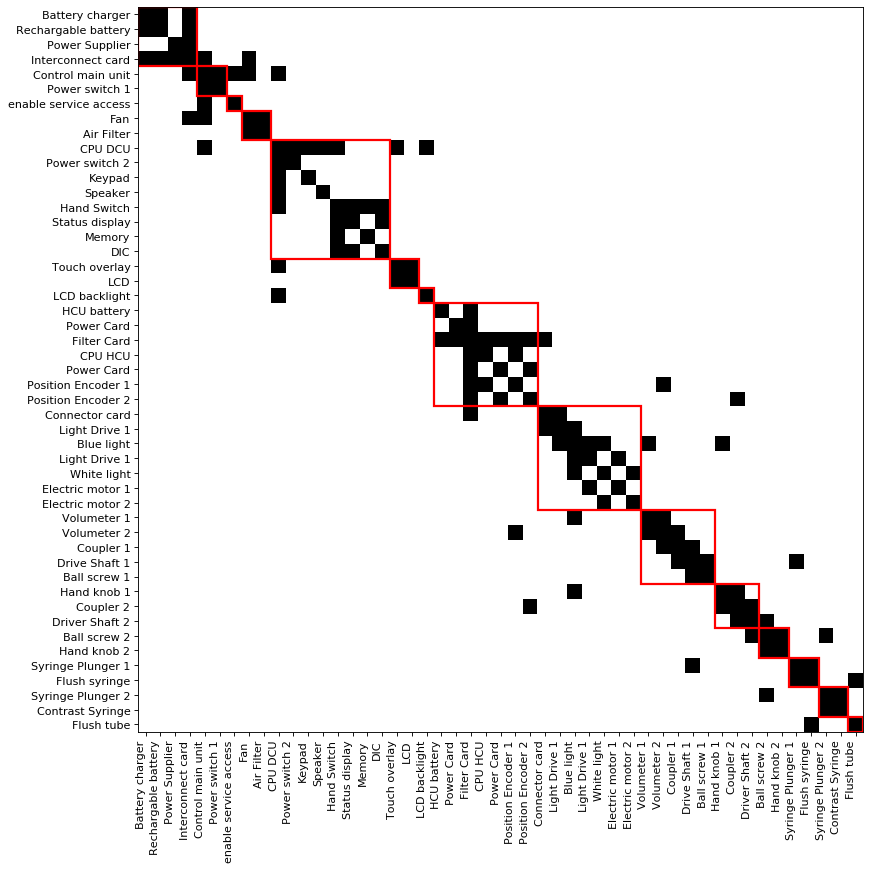

In [11]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import patches

element_list = []
for i in range(np.max(env.min_cluster_seq)):
  element_list=element_list+list(np.where(np.array(env.min_cluster_seq)==i)[0])
element_list = np.array(element_list)
New_Cluster = np.array(env.min_cluster_seq)[np.array(element_list)]
New_DSM = np.array([env.DSM[i][element_list] for i in element_list])

fig, ax = plt.subplots(num=None, figsize=(16, 12), dpi=80, facecolor='w', edgecolor='k')
ax.imshow(1-New_DSM,cmap='gray')
ax.set_xticks(list(range(New_DSM.shape[0])))
ax.set_xticklabels(Components, rotation=90, horizontalalignment='right')
ax.set_yticks(list(range(New_DSM.shape[0])))
ax.set_yticklabels(Components)
for s in np.unique(New_Cluster):
  i = np.where(New_Cluster==s)[0][0]
  l = len(np.where(New_Cluster==s)[0])
  rect = patches.Rectangle((i-0.5,i-0.5),l,l,linewidth=2,edgecolor='r',facecolor='none')
  ax.add_patch(rect)

In [0]:
book.sheet_names()